In [17]:
import torch
import torch.nn as nn
import numpy as np

def embed_signal_torch(data, n_delays, delay_interval=1):
    """
    Create a delay embedding from the provided tensor data.

    Parameters
    ----------
    data : torch.tensor
        The data from which to create the delay embedding. Must be either: 
        a 3-dimensional array/tensor of shape
        K x T x N where K is the number of "trials" and T and N are
        as defined above.

    n_delays : int
        Parameter that controls the size of the delay embedding. Explicitly,
        the number of delays to include.

    delay_interval : int
        The number of time steps between each delay in the delay embedding. Defaults
        to 1 time step.
    """
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data)
    device = data.device

    b,time, dim = data.shape
    if data.shape[int(data.ndim==3)] - (n_delays - 1)*delay_interval < 1:
        raise ValueError("The number of delays is too large for the number of time points in the data!")

    # initialize the embedding
    embedding = torch.zeros((b,time,dim*n_delays)).to(device)
    
    for d in range(n_delays):

        ddelay = d*delay_interval

        ddata = d*dim
        delayed_data = data[:,:time-ddelay]
        print(delayed_data.shape)

        embedding[:,ddelay:, ddata: ddata + data.shape[2]] = delayed_data
    
    return embedding

In [18]:
data = np.random.random((1,10,1))

H = embed_signal_torch(data, 3, 2)
data

torch.Size([1, 10, 1])
torch.Size([1, 8, 1])
torch.Size([1, 6, 1])


array([[[0.61380365],
        [0.77000336],
        [0.80787665],
        [0.4149357 ],
        [0.2187207 ],
        [0.7633089 ],
        [0.88267687],
        [0.13730199],
        [0.96373792],
        [0.95824041]]])

In [19]:
H

tensor([[[0.6138, 0.0000, 0.0000],
         [0.7700, 0.0000, 0.0000],
         [0.8079, 0.6138, 0.0000],
         [0.4149, 0.7700, 0.0000],
         [0.2187, 0.8079, 0.6138],
         [0.7633, 0.4149, 0.7700],
         [0.8827, 0.2187, 0.8079],
         [0.1373, 0.7633, 0.4149],
         [0.9637, 0.8827, 0.2187],
         [0.9582, 0.1373, 0.7633]]])

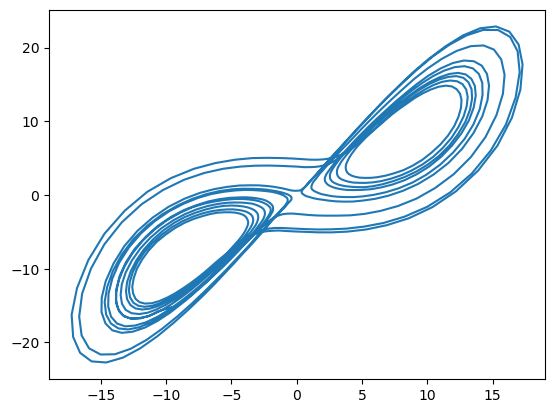

In [20]:
import matplotlib.pyplot as plt
import numpy as np

from dysts.flows import Lorenz, Hadley

## Load and simulate an attractor
model = Lorenz()
sol = model.make_trajectory(1000, resample=True, noise=0.01)
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])

In [61]:
from utils import train, make_dataset

# from train import train
from torch.optim import AdamW
import sys

%load_ext autoreload
%autoreload 2
sys.path.append("/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings")
from src.models import DelayedMLP


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
dmlp = DelayedMLP(input_dim=1,hidden_dims=[10,50,10],output_dim=1,n_delays=10,delay_interval=1)

In [47]:
import torch.nn as nn

train_loader, val_loader, train_data, val_data = make_dataset(Lorenz, 1000, 20)
train_data = train_data[:,:,0:1]
val_data = val_data[:,:,0:1]
d = next(iter(train_loader))
d.shape

(20, 1000, 3) torch.Size([20, 1000, 1])
(20, 1000, 3) torch.Size([20, 1000, 1])


torch.Size([1, 1000, 1])

In [51]:
#standard scale the data
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
scaler = StandardScaler()



train_data = scaler.fit_transform(train_data.reshape(-1,d.shape[-1])).reshape(*train_data.shape)
val_data = scaler.transform(val_data.reshape(-1,d.shape[-1])).reshape(*val_data.shape)

train_data = torch.Tensor(train_data).float()
val_data = torch.Tensor(val_data).float()

#put back into a dataloader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 27/1000 [00:00<00:07, 136.16it/s]

Epoch 0 Training Loss: 1.0094356536865234
Epoch 0 Validation Loss: 1.0117988586425781
Epoch 1 Training Loss: 1.0041013956069946
Epoch 1 Validation Loss: 1.0056756734848022
Epoch 2 Training Loss: 0.9991157054901123
Epoch 2 Validation Loss: 0.999764621257782
Epoch 3 Training Loss: 0.9943215847015381
Epoch 3 Validation Loss: 0.9939181208610535
Epoch 4 Training Loss: 0.9895933270454407
Epoch 4 Validation Loss: 0.9882148504257202
Epoch 5 Training Loss: 0.9850029945373535
Epoch 5 Validation Loss: 0.9834666848182678
Epoch 6 Training Loss: 0.9812228083610535
Epoch 6 Validation Loss: 0.9789924621582031
Epoch 7 Training Loss: 0.9776548743247986
Epoch 7 Validation Loss: 0.9746078848838806
Epoch 8 Training Loss: 0.974148154258728
Epoch 8 Validation Loss: 0.9701392650604248
Epoch 9 Training Loss: 0.9705668687820435
Epoch 9 Validation Loss: 0.9656898379325867
Epoch 10 Training Loss: 0.9670270085334778
Epoch 10 Validation Loss: 0.9613255858421326
Epoch 11 Training Loss: 0.9635786414146423
Epoch 11 Va

  6%|▌         | 55/1000 [00:00<00:07, 131.80it/s]

Epoch 30 Training Loss: 0.8901351690292358
Epoch 30 Validation Loss: 0.8647611737251282
Epoch 31 Training Loss: 0.8859668374061584
Epoch 31 Validation Loss: 0.8595863580703735
Epoch 32 Training Loss: 0.8817997574806213
Epoch 32 Validation Loss: 0.8544169068336487
Epoch 33 Training Loss: 0.8776366114616394
Epoch 33 Validation Loss: 0.8492583632469177
Epoch 34 Training Loss: 0.8734622597694397
Epoch 34 Validation Loss: 0.8442968130111694
Epoch 35 Training Loss: 0.8694274425506592
Epoch 35 Validation Loss: 0.839619517326355
Epoch 36 Training Loss: 0.8656349778175354
Epoch 36 Validation Loss: 0.8349743485450745
Epoch 37 Training Loss: 0.8618896007537842
Epoch 37 Validation Loss: 0.8303785920143127
Epoch 38 Training Loss: 0.8581966757774353
Epoch 38 Validation Loss: 0.8258619904518127
Epoch 39 Training Loss: 0.8545719385147095
Epoch 39 Validation Loss: 0.8214455842971802
Epoch 40 Training Loss: 0.8510207533836365
Epoch 40 Validation Loss: 0.8171527981758118
Epoch 41 Training Loss: 0.8475493

  8%|▊         | 84/1000 [00:00<00:06, 136.08it/s]

Epoch 58 Validation Loss: 0.7663391828536987
Epoch 59 Training Loss: 0.7989470958709717
Epoch 59 Validation Loss: 0.764773428440094
Epoch 60 Training Loss: 0.7975131273269653
Epoch 60 Validation Loss: 0.7632450461387634
Epoch 61 Training Loss: 0.7960847616195679
Epoch 61 Validation Loss: 0.7617342472076416
Epoch 62 Training Loss: 0.7946963310241699
Epoch 62 Validation Loss: 0.7602453231811523
Epoch 63 Training Loss: 0.7934539318084717
Epoch 63 Validation Loss: 0.7587099671363831
Epoch 64 Training Loss: 0.7922742366790771
Epoch 64 Validation Loss: 0.7571353316307068
Epoch 65 Training Loss: 0.7911306619644165
Epoch 65 Validation Loss: 0.7555333375930786
Epoch 66 Training Loss: 0.7900299429893494
Epoch 66 Validation Loss: 0.7539328336715698
Epoch 67 Training Loss: 0.7889834046363831
Epoch 67 Validation Loss: 0.7523452043533325
Epoch 68 Training Loss: 0.7879887819290161
Epoch 68 Validation Loss: 0.7507790923118591
Epoch 69 Training Loss: 0.7870371341705322
Epoch 69 Validation Loss: 0.74925

 11%|█▏        | 114/1000 [00:00<00:06, 142.55it/s]

Epoch 87 Training Loss: 0.7774190306663513
Epoch 87 Validation Loss: 0.7347197532653809
Epoch 88 Training Loss: 0.7770835161209106
Epoch 88 Validation Loss: 0.7342848181724548
Epoch 89 Training Loss: 0.7767449021339417
Epoch 89 Validation Loss: 0.7338688373565674
Epoch 90 Training Loss: 0.7764025330543518
Epoch 90 Validation Loss: 0.73347407579422
Epoch 91 Training Loss: 0.776053786277771
Epoch 91 Validation Loss: 0.7331022024154663
Epoch 92 Training Loss: 0.7756990194320679
Epoch 92 Validation Loss: 0.73275226354599
Epoch 93 Training Loss: 0.7753419876098633
Epoch 93 Validation Loss: 0.7324278354644775
Epoch 94 Training Loss: 0.7749890685081482
Epoch 94 Validation Loss: 0.7321348190307617
Epoch 95 Training Loss: 0.7746572494506836
Epoch 95 Validation Loss: 0.7318400740623474
Epoch 96 Training Loss: 0.7743226885795593
Epoch 96 Validation Loss: 0.7315419912338257
Epoch 97 Training Loss: 0.773990273475647
Epoch 97 Validation Loss: 0.7312365174293518
Epoch 98 Training Loss: 0.773659765720

 14%|█▍        | 145/1000 [00:01<00:05, 146.86it/s]

Epoch 118 Training Loss: 0.7674242258071899
Epoch 118 Validation Loss: 0.7242559194564819
Epoch 119 Training Loss: 0.7670944333076477
Epoch 119 Validation Loss: 0.7238306403160095
Epoch 120 Training Loss: 0.7667618989944458
Epoch 120 Validation Loss: 0.7234026789665222
Epoch 121 Training Loss: 0.7664263844490051
Epoch 121 Validation Loss: 0.7229746580123901
Epoch 122 Training Loss: 0.76608806848526
Epoch 122 Validation Loss: 0.7225502133369446
Epoch 123 Training Loss: 0.7657467722892761
Epoch 123 Validation Loss: 0.7221287488937378
Epoch 124 Training Loss: 0.7654029130935669
Epoch 124 Validation Loss: 0.7217105627059937
Epoch 125 Training Loss: 0.7650576233863831
Epoch 125 Validation Loss: 0.7212952375411987
Epoch 126 Training Loss: 0.7647114992141724
Epoch 126 Validation Loss: 0.7208826541900635
Epoch 127 Training Loss: 0.7643651366233826
Epoch 127 Validation Loss: 0.720469057559967
Epoch 128 Training Loss: 0.7640183568000793
Epoch 128 Validation Loss: 0.7200503349304199
Epoch 129 Tra

 18%|█▊        | 177/1000 [00:01<00:05, 151.61it/s]

Epoch 149 Training Loss: 0.7560526132583618
Epoch 149 Validation Loss: 0.7107813954353333
Epoch 150 Training Loss: 0.7556188106536865
Epoch 150 Validation Loss: 0.7102723121643066
Epoch 151 Training Loss: 0.7551746368408203
Epoch 151 Validation Loss: 0.70975261926651
Epoch 152 Training Loss: 0.7547239661216736
Epoch 152 Validation Loss: 0.7092232704162598
Epoch 153 Training Loss: 0.7542656064033508
Epoch 153 Validation Loss: 0.7086820602416992
Epoch 154 Training Loss: 0.7537992000579834
Epoch 154 Validation Loss: 0.7081328630447388
Epoch 155 Training Loss: 0.7533225417137146
Epoch 155 Validation Loss: 0.707577645778656
Epoch 156 Training Loss: 0.7528396248817444
Epoch 156 Validation Loss: 0.7070174813270569
Epoch 157 Training Loss: 0.7523492574691772
Epoch 157 Validation Loss: 0.7064498066902161
Epoch 158 Training Loss: 0.7518548369407654
Epoch 158 Validation Loss: 0.7058711647987366
Epoch 159 Training Loss: 0.7513545751571655
Epoch 159 Validation Loss: 0.705280601978302
Epoch 160 Trai

 21%|██        | 209/1000 [00:01<00:05, 152.89it/s]

Epoch 181 Training Loss: 0.7396856546401978
Epoch 181 Validation Loss: 0.691694438457489
Epoch 182 Training Loss: 0.7391456961631775
Epoch 182 Validation Loss: 0.6910771131515503
Epoch 183 Training Loss: 0.7386060953140259
Epoch 183 Validation Loss: 0.690461277961731
Epoch 184 Training Loss: 0.7380625009536743
Epoch 184 Validation Loss: 0.6898438334465027
Epoch 185 Training Loss: 0.7375141978263855
Epoch 185 Validation Loss: 0.6892268061637878
Epoch 186 Training Loss: 0.7369604706764221
Epoch 186 Validation Loss: 0.6886040568351746
Epoch 187 Training Loss: 0.7363975644111633
Epoch 187 Validation Loss: 0.6879612803459167
Epoch 188 Training Loss: 0.7358254790306091
Epoch 188 Validation Loss: 0.6872988939285278
Epoch 189 Training Loss: 0.735244631767273
Epoch 189 Validation Loss: 0.6866188049316406
Epoch 190 Training Loss: 0.7346475720405579
Epoch 190 Validation Loss: 0.6859301924705505
Epoch 191 Training Loss: 0.7340478301048279
Epoch 191 Validation Loss: 0.6852218508720398
Epoch 192 Tra

 24%|██▍       | 241/1000 [00:01<00:04, 156.03it/s]

Epoch 213 Training Loss: 0.718481719493866
Epoch 213 Validation Loss: 0.667335569858551
Epoch 214 Training Loss: 0.7176240682601929
Epoch 214 Validation Loss: 0.6665690541267395
Epoch 215 Training Loss: 0.7167292237281799
Epoch 215 Validation Loss: 0.6655740141868591
Epoch 216 Training Loss: 0.7157266736030579
Epoch 216 Validation Loss: 0.6636489629745483
Epoch 217 Training Loss: 0.7143874764442444
Epoch 217 Validation Loss: 0.6613646149635315
Epoch 218 Training Loss: 0.7131776213645935
Epoch 218 Validation Loss: 0.6595749855041504
Epoch 219 Training Loss: 0.7120409607887268
Epoch 219 Validation Loss: 0.6583974361419678
Epoch 220 Training Loss: 0.7108400464057922
Epoch 220 Validation Loss: 0.6577194333076477
Epoch 221 Training Loss: 0.7096132040023804
Epoch 221 Validation Loss: 0.6572011709213257
Epoch 222 Training Loss: 0.708434522151947
Epoch 222 Validation Loss: 0.6563057899475098
Epoch 223 Training Loss: 0.707245409488678
Epoch 223 Validation Loss: 0.6546918749809265
Epoch 224 Trai

 27%|██▋       | 273/1000 [00:01<00:04, 155.24it/s]

Epoch 245 Training Loss: 0.6766294836997986
Epoch 245 Validation Loss: 0.6195699572563171
Epoch 246 Training Loss: 0.6751567125320435
Epoch 246 Validation Loss: 0.6181936860084534
Epoch 247 Training Loss: 0.6736555695533752
Epoch 247 Validation Loss: 0.61683189868927
Epoch 248 Training Loss: 0.6721510291099548
Epoch 248 Validation Loss: 0.614918053150177
Epoch 249 Training Loss: 0.6706101894378662
Epoch 249 Validation Loss: 0.6126013994216919
Epoch 250 Training Loss: 0.6690048575401306
Epoch 250 Validation Loss: 0.6105059385299683
Epoch 251 Training Loss: 0.6674094796180725
Epoch 251 Validation Loss: 0.6089644432067871
Epoch 252 Training Loss: 0.6657887101173401
Epoch 252 Validation Loss: 0.6076566576957703
Epoch 253 Training Loss: 0.6641519665718079
Epoch 253 Validation Loss: 0.6060498952865601
Epoch 254 Training Loss: 0.6625038385391235
Epoch 254 Validation Loss: 0.6039450764656067
Epoch 255 Training Loss: 0.6608238220214844
Epoch 255 Validation Loss: 0.6017293930053711
Epoch 256 Tra

 31%|███       | 306/1000 [00:02<00:04, 155.62it/s]

Epoch 277 Training Loss: 0.6182543039321899
Epoch 277 Validation Loss: 0.5563197135925293
Epoch 278 Training Loss: 0.6161543130874634
Epoch 278 Validation Loss: 0.5539244413375854
Epoch 279 Training Loss: 0.614048421382904
Epoch 279 Validation Loss: 0.5519599914550781
Epoch 280 Training Loss: 0.6119263172149658
Epoch 280 Validation Loss: 0.549776017665863
Epoch 281 Training Loss: 0.6097860336303711
Epoch 281 Validation Loss: 0.5475391149520874
Epoch 282 Training Loss: 0.6076349020004272
Epoch 282 Validation Loss: 0.545373260974884
Epoch 283 Training Loss: 0.6054770350456238
Epoch 283 Validation Loss: 0.5428158640861511
Epoch 284 Training Loss: 0.6033158898353577
Epoch 284 Validation Loss: 0.5408305525779724
Epoch 285 Training Loss: 0.6011528372764587
Epoch 285 Validation Loss: 0.5385702252388
Epoch 286 Training Loss: 0.5989929437637329
Epoch 286 Validation Loss: 0.5364062190055847
Epoch 287 Training Loss: 0.5968267321586609
Epoch 287 Validation Loss: 0.5341537594795227
Epoch 288 Traini

 34%|███▍      | 339/1000 [00:02<00:04, 157.19it/s]

Epoch 309 Training Loss: 0.5424079895019531
Epoch 309 Validation Loss: 0.47992104291915894
Epoch 310 Training Loss: 0.5392587780952454
Epoch 310 Validation Loss: 0.47727423906326294
Epoch 311 Training Loss: 0.536162257194519
Epoch 311 Validation Loss: 0.47357192635536194
Epoch 312 Training Loss: 0.5331367254257202
Epoch 312 Validation Loss: 0.47265419363975525
Epoch 313 Training Loss: 0.5301828980445862
Epoch 313 Validation Loss: 0.4695245921611786
Epoch 314 Training Loss: 0.5273348689079285
Epoch 314 Validation Loss: 0.4672437012195587
Epoch 315 Training Loss: 0.5244706869125366
Epoch 315 Validation Loss: 0.46534430980682373
Epoch 316 Training Loss: 0.5215564370155334
Epoch 316 Validation Loss: 0.46153175830841064
Epoch 317 Training Loss: 0.518733024597168
Epoch 317 Validation Loss: 0.4598288834095001
Epoch 318 Training Loss: 0.5159290432929993
Epoch 318 Validation Loss: 0.45639047026634216
Epoch 319 Training Loss: 0.5130589008331299
Epoch 319 Validation Loss: 0.4533570110797882
Epoch

 36%|███▌      | 355/1000 [00:02<00:04, 150.39it/s]

Epoch 341 Training Loss: 0.45495572686195374
Epoch 341 Validation Loss: 0.4015244245529175
Epoch 342 Training Loss: 0.45252177119255066
Epoch 342 Validation Loss: 0.3995075523853302
Epoch 343 Training Loss: 0.45013293623924255
Epoch 343 Validation Loss: 0.3972574770450592
Epoch 344 Training Loss: 0.4478282034397125
Epoch 344 Validation Loss: 0.39592528343200684
Epoch 345 Training Loss: 0.4455587565898895
Epoch 345 Validation Loss: 0.3930318057537079
Epoch 346 Training Loss: 0.4433154761791229
Epoch 346 Validation Loss: 0.3919050097465515
Epoch 347 Training Loss: 0.44111552834510803
Epoch 347 Validation Loss: 0.3889921307563782
Epoch 348 Training Loss: 0.43894901871681213
Epoch 348 Validation Loss: 0.3881824314594269
Epoch 349 Training Loss: 0.43680500984191895
Epoch 349 Validation Loss: 0.3853367567062378
Epoch 350 Training Loss: 0.4346834123134613
Epoch 350 Validation Loss: 0.3845174312591553
Epoch 351 Training Loss: 0.4325682520866394
Epoch 351 Validation Loss: 0.3816746473312378
Epo

 40%|████      | 405/1000 [00:02<00:03, 156.03it/s]

Epoch 372 Training Loss: 0.39646419882774353
Epoch 372 Validation Loss: 0.354326456785202
Epoch 373 Training Loss: 0.39504656195640564
Epoch 373 Validation Loss: 0.35252001881599426
Epoch 374 Training Loss: 0.393633633852005
Epoch 374 Validation Loss: 0.35154613852500916
Epoch 375 Training Loss: 0.39230576157569885
Epoch 375 Validation Loss: 0.35105499625205994
Epoch 376 Training Loss: 0.3910326659679413
Epoch 376 Validation Loss: 0.3491825461387634
Epoch 377 Training Loss: 0.3897566795349121
Epoch 377 Validation Loss: 0.34942084550857544
Epoch 378 Training Loss: 0.3884449303150177
Epoch 378 Validation Loss: 0.34728121757507324
Epoch 379 Training Loss: 0.3871150016784668
Epoch 379 Validation Loss: 0.3470284640789032
Epoch 380 Training Loss: 0.3857836127281189
Epoch 380 Validation Loss: 0.34605953097343445
Epoch 381 Training Loss: 0.3845430314540863
Epoch 381 Validation Loss: 0.3448408246040344
Epoch 382 Training Loss: 0.383417546749115
Epoch 382 Validation Loss: 0.3450177013874054
Epoc

 42%|████▏     | 422/1000 [00:02<00:03, 158.14it/s]

Epoch 405 Training Loss: 0.35996171832084656
Epoch 405 Validation Loss: 0.3267097473144531
Epoch 406 Training Loss: 0.3589993715286255
Epoch 406 Validation Loss: 0.32622140645980835
Epoch 407 Training Loss: 0.3580402135848999
Epoch 407 Validation Loss: 0.3251068592071533
Epoch 408 Training Loss: 0.3570858836174011
Epoch 408 Validation Loss: 0.32501623034477234
Epoch 409 Training Loss: 0.3561538755893707
Epoch 409 Validation Loss: 0.32351669669151306
Epoch 410 Training Loss: 0.35525935888290405
Epoch 410 Validation Loss: 0.32402440905570984
Epoch 411 Training Loss: 0.3544195592403412
Epoch 411 Validation Loss: 0.3215636909008026
Epoch 412 Training Loss: 0.35365569591522217
Epoch 412 Validation Loss: 0.32342374324798584
Epoch 413 Training Loss: 0.3529435694217682
Epoch 413 Validation Loss: 0.31976479291915894
Epoch 414 Training Loss: 0.3520188629627228
Epoch 414 Validation Loss: 0.32085496187210083
Epoch 415 Training Loss: 0.35081052780151367
Epoch 415 Validation Loss: 0.3190039992332458

 45%|████▌     | 454/1000 [00:03<00:03, 155.09it/s]

Epoch 437 Validation Loss: 0.3002871870994568
Epoch 438 Training Loss: 0.32908445596694946
Epoch 438 Validation Loss: 0.29988640546798706
Epoch 439 Training Loss: 0.3283316493034363
Epoch 439 Validation Loss: 0.2979917526245117
Epoch 440 Training Loss: 0.3276328444480896
Epoch 440 Validation Loss: 0.29801660776138306
Epoch 441 Training Loss: 0.326823890209198
Epoch 441 Validation Loss: 0.29662397503852844
Epoch 442 Training Loss: 0.32591989636421204
Epoch 442 Validation Loss: 0.2959003448486328
Epoch 443 Training Loss: 0.3250325918197632
Epoch 443 Validation Loss: 0.2955593168735504
Epoch 444 Training Loss: 0.32422053813934326
Epoch 444 Validation Loss: 0.2945205867290497
Epoch 445 Training Loss: 0.3234716057777405
Epoch 445 Validation Loss: 0.29466113448143005
Epoch 446 Training Loss: 0.3226906657218933
Epoch 446 Validation Loss: 0.2935168147087097
Epoch 447 Training Loss: 0.3218994438648224
Epoch 447 Validation Loss: 0.2931016981601715
Epoch 448 Training Loss: 0.3211326003074646
Epoc

 49%|████▊     | 487/1000 [00:03<00:03, 157.98it/s]

Epoch 469 Training Loss: 0.3067925274372101
Epoch 469 Validation Loss: 0.2791421413421631
Epoch 470 Training Loss: 0.3061892092227936
Epoch 470 Validation Loss: 0.2793867886066437
Epoch 471 Training Loss: 0.3056102991104126
Epoch 471 Validation Loss: 0.2780473232269287
Epoch 472 Training Loss: 0.30506208539009094
Epoch 472 Validation Loss: 0.27886852622032166
Epoch 473 Training Loss: 0.3045612573623657
Epoch 473 Validation Loss: 0.276824027299881
Epoch 474 Training Loss: 0.30405497550964355
Epoch 474 Validation Loss: 0.2779909372329712
Epoch 475 Training Loss: 0.3034944534301758
Epoch 475 Validation Loss: 0.2758302390575409
Epoch 476 Training Loss: 0.3027610182762146
Epoch 476 Validation Loss: 0.276225209236145
Epoch 477 Training Loss: 0.3019223213195801
Epoch 477 Validation Loss: 0.2749660015106201
Epoch 478 Training Loss: 0.3011404573917389
Epoch 478 Validation Loss: 0.2744986116886139
Epoch 479 Training Loss: 0.3005293309688568
Epoch 479 Validation Loss: 0.2745150923728943
Epoch 480

 52%|█████▏    | 519/1000 [00:03<00:03, 156.89it/s]

Epoch 501 Training Loss: 0.2872186601161957
Epoch 501 Validation Loss: 0.26020532846450806
Epoch 502 Training Loss: 0.2865378260612488
Epoch 502 Validation Loss: 0.2604506313800812
Epoch 503 Training Loss: 0.2855678200721741
Epoch 503 Validation Loss: 0.2590689957141876
Epoch 504 Training Loss: 0.2847278118133545
Epoch 504 Validation Loss: 0.2578723132610321
Epoch 505 Training Loss: 0.28419750928878784
Epoch 505 Validation Loss: 0.2582763433456421
Epoch 506 Training Loss: 0.2837192118167877
Epoch 506 Validation Loss: 0.2565149962902069
Epoch 507 Training Loss: 0.2829836308956146
Epoch 507 Validation Loss: 0.25627100467681885
Epoch 508 Training Loss: 0.28208300471305847
Epoch 508 Validation Loss: 0.2554071247577667
Epoch 509 Training Loss: 0.28129881620407104
Epoch 509 Validation Loss: 0.25441548228263855
Epoch 510 Training Loss: 0.2807062864303589
Epoch 510 Validation Loss: 0.25453659892082214
Epoch 511 Training Loss: 0.2800968587398529
Epoch 511 Validation Loss: 0.2532119154930115
Epo

 55%|█████▌    | 552/1000 [00:03<00:02, 156.96it/s]

Epoch 532 Training Loss: 0.2658246159553528
Epoch 532 Validation Loss: 0.23976574838161469
Epoch 533 Training Loss: 0.26520836353302
Epoch 533 Validation Loss: 0.24012470245361328
Epoch 534 Training Loss: 0.2646384537220001
Epoch 534 Validation Loss: 0.2384350597858429
Epoch 535 Training Loss: 0.2640976309776306
Epoch 535 Validation Loss: 0.23937873542308807
Epoch 536 Training Loss: 0.2635549008846283
Epoch 536 Validation Loss: 0.23727025091648102
Epoch 537 Training Loss: 0.2629354000091553
Epoch 537 Validation Loss: 0.23797273635864258
Epoch 538 Training Loss: 0.2621835470199585
Epoch 538 Validation Loss: 0.23571468889713287
Epoch 539 Training Loss: 0.26120176911354065
Epoch 539 Validation Loss: 0.23567645251750946
Epoch 540 Training Loss: 0.26017531752586365
Epoch 540 Validation Loss: 0.2343664914369583
Epoch 541 Training Loss: 0.25929245352745056
Epoch 541 Validation Loss: 0.2335292249917984
Epoch 542 Training Loss: 0.2586471140384674
Epoch 542 Validation Loss: 0.23374043405056
Epoc

 58%|█████▊    | 584/1000 [00:03<00:02, 155.75it/s]

Epoch 564 Training Loss: 0.2425704449415207
Epoch 564 Validation Loss: 0.2174188792705536
Epoch 565 Training Loss: 0.24151994287967682
Epoch 565 Validation Loss: 0.21652303636074066
Epoch 566 Training Loss: 0.24067360162734985
Epoch 566 Validation Loss: 0.21554002165794373
Epoch 567 Training Loss: 0.24003808200359344
Epoch 567 Validation Loss: 0.21575619280338287
Epoch 568 Training Loss: 0.23951712250709534
Epoch 568 Validation Loss: 0.21412751078605652
Epoch 569 Training Loss: 0.2390521913766861
Epoch 569 Validation Loss: 0.21517224609851837
Epoch 570 Training Loss: 0.23845070600509644
Epoch 570 Validation Loss: 0.2125643640756607
Epoch 571 Training Loss: 0.237496480345726
Epoch 571 Validation Loss: 0.2125617116689682
Epoch 572 Training Loss: 0.23630861937999725
Epoch 572 Validation Loss: 0.2108042687177658
Epoch 573 Training Loss: 0.23520053923130035
Epoch 573 Validation Loss: 0.2101968228816986
Epoch 574 Training Loss: 0.2344454526901245
Epoch 574 Validation Loss: 0.2103747725486755

 62%|██████▏   | 616/1000 [00:04<00:02, 156.37it/s]

Epoch 596 Training Loss: 0.21812833845615387
Epoch 596 Validation Loss: 0.19277839362621307
Epoch 597 Training Loss: 0.21755442023277283
Epoch 597 Validation Loss: 0.1934482753276825
Epoch 598 Training Loss: 0.21698607504367828
Epoch 598 Validation Loss: 0.19161511957645416
Epoch 599 Training Loss: 0.21633151173591614
Epoch 599 Validation Loss: 0.1918533891439438
Epoch 600 Training Loss: 0.21561266481876373
Epoch 600 Validation Loss: 0.189692884683609
Epoch 601 Training Loss: 0.2147473692893982
Epoch 601 Validation Loss: 0.19002483785152435
Epoch 602 Training Loss: 0.21379919350147247
Epoch 602 Validation Loss: 0.1882958859205246
Epoch 603 Training Loss: 0.21284233033657074
Epoch 603 Validation Loss: 0.18777412176132202
Epoch 604 Training Loss: 0.21196983754634857
Epoch 604 Validation Loss: 0.18684643507003784
Epoch 605 Training Loss: 0.21120771765708923
Epoch 605 Validation Loss: 0.1858464479446411
Epoch 606 Training Loss: 0.21052902936935425
Epoch 606 Validation Loss: 0.1858663558959

 65%|██████▍   | 648/1000 [00:04<00:02, 154.91it/s]

Epoch 628 Training Loss: 0.19661933183670044
Epoch 628 Validation Loss: 0.1702248752117157
Epoch 629 Training Loss: 0.19497765600681305
Epoch 629 Validation Loss: 0.1699724644422531
Epoch 630 Training Loss: 0.19376301765441895
Epoch 630 Validation Loss: 0.1694989949464798
Epoch 631 Training Loss: 0.1932642161846161
Epoch 631 Validation Loss: 0.16855771839618683
Epoch 632 Training Loss: 0.1931687891483307
Epoch 632 Validation Loss: 0.1699073761701584
Epoch 633 Training Loss: 0.19299958646297455
Epoch 633 Validation Loss: 0.16725333034992218
Epoch 634 Training Loss: 0.19213798642158508
Epoch 634 Validation Loss: 0.16763679683208466
Epoch 635 Training Loss: 0.1909874975681305
Epoch 635 Validation Loss: 0.16626998782157898
Epoch 636 Training Loss: 0.19006618857383728
Epoch 636 Validation Loss: 0.1655559539794922
Epoch 637 Training Loss: 0.18967659771442413
Epoch 637 Validation Loss: 0.16638949513435364
Epoch 638 Training Loss: 0.18951864540576935
Epoch 638 Validation Loss: 0.16450044512748

 68%|██████▊   | 680/1000 [00:04<00:02, 153.37it/s]

Epoch 659 Training Loss: 0.17747144401073456
Epoch 659 Validation Loss: 0.15391458570957184
Epoch 660 Training Loss: 0.17695701122283936
Epoch 660 Validation Loss: 0.15407292544841766
Epoch 661 Training Loss: 0.17647038400173187
Epoch 661 Validation Loss: 0.15281297266483307
Epoch 662 Training Loss: 0.17595162987709045
Epoch 662 Validation Loss: 0.15307511389255524
Epoch 663 Training Loss: 0.17545370757579803
Epoch 663 Validation Loss: 0.15205618739128113
Epoch 664 Training Loss: 0.1749306619167328
Epoch 664 Validation Loss: 0.15241315960884094
Epoch 665 Training Loss: 0.17442850768566132
Epoch 665 Validation Loss: 0.1512814164161682
Epoch 666 Training Loss: 0.17392389476299286
Epoch 666 Validation Loss: 0.15119823813438416
Epoch 667 Training Loss: 0.17344188690185547
Epoch 667 Validation Loss: 0.15051484107971191
Epoch 668 Training Loss: 0.1729660928249359
Epoch 668 Validation Loss: 0.15044191479682922
Epoch 669 Training Loss: 0.17250527441501617
Epoch 669 Validation Loss: 0.149898648

 71%|███████▏  | 713/1000 [00:04<00:01, 156.19it/s]

Epoch 691 Training Loss: 0.1634630560874939
Epoch 691 Validation Loss: 0.1434529572725296
Epoch 692 Training Loss: 0.16373397409915924
Epoch 692 Validation Loss: 0.14181749522686005
Epoch 693 Training Loss: 0.16418734192848206
Epoch 693 Validation Loss: 0.14273898303508759
Epoch 694 Training Loss: 0.16361768543720245
Epoch 694 Validation Loss: 0.14024144411087036
Epoch 695 Training Loss: 0.16221372783184052
Epoch 695 Validation Loss: 0.14047493040561676
Epoch 696 Training Loss: 0.16185544431209564
Epoch 696 Validation Loss: 0.14220590889453888
Epoch 697 Training Loss: 0.16225869953632355
Epoch 697 Validation Loss: 0.1399002969264984
Epoch 698 Training Loss: 0.1619466096162796
Epoch 698 Validation Loss: 0.13995826244354248
Epoch 699 Training Loss: 0.1609669178724289
Epoch 699 Validation Loss: 0.13912418484687805
Epoch 700 Training Loss: 0.16031019389629364
Epoch 700 Validation Loss: 0.13888321816921234
Epoch 701 Training Loss: 0.16040264070034027
Epoch 701 Validation Loss: 0.14020226895

 74%|███████▍  | 745/1000 [00:04<00:01, 151.85it/s]

Epoch 723 Training Loss: 0.15308719873428345
Epoch 723 Validation Loss: 0.13267289102077484
Epoch 724 Training Loss: 0.1527407318353653
Epoch 724 Validation Loss: 0.1323489397764206
Epoch 725 Training Loss: 0.1524362415075302
Epoch 725 Validation Loss: 0.13166378438472748
Epoch 726 Training Loss: 0.1521638035774231
Epoch 726 Validation Loss: 0.13172662258148193
Epoch 727 Training Loss: 0.1518944501876831
Epoch 727 Validation Loss: 0.13119429349899292
Epoch 728 Training Loss: 0.1515921950340271
Epoch 728 Validation Loss: 0.13142244517803192
Epoch 729 Training Loss: 0.15128348767757416
Epoch 729 Validation Loss: 0.13084499537944794
Epoch 730 Training Loss: 0.1509750932455063
Epoch 730 Validation Loss: 0.1305709183216095
Epoch 731 Training Loss: 0.15068785846233368
Epoch 731 Validation Loss: 0.13030022382736206
Epoch 732 Training Loss: 0.1504066288471222
Epoch 732 Validation Loss: 0.1300354301929474
Epoch 733 Training Loss: 0.1501256376504898
Epoch 733 Validation Loss: 0.12992306053638458

 78%|███████▊  | 778/1000 [00:05<00:01, 155.19it/s]

Epoch 754 Training Loss: 0.14596238732337952
Epoch 754 Validation Loss: 0.12633585929870605
Epoch 755 Training Loss: 0.14772164821624756
Epoch 755 Validation Loss: 0.1286148875951767
Epoch 756 Training Loss: 0.14746826887130737
Epoch 756 Validation Loss: 0.1234472393989563
Epoch 757 Training Loss: 0.1445261687040329
Epoch 757 Validation Loss: 0.12411828339099884
Epoch 758 Training Loss: 0.14416790008544922
Epoch 758 Validation Loss: 0.12841880321502686
Epoch 759 Training Loss: 0.14596256613731384
Epoch 759 Validation Loss: 0.12463812530040741
Epoch 760 Training Loss: 0.14529739320278168
Epoch 760 Validation Loss: 0.12361860275268555
Epoch 761 Training Loss: 0.14350304007530212
Epoch 761 Validation Loss: 0.12306134402751923
Epoch 762 Training Loss: 0.14308863878250122
Epoch 762 Validation Loss: 0.12331380695104599
Epoch 763 Training Loss: 0.14395657181739807
Epoch 763 Validation Loss: 0.1257396936416626
Epoch 764 Training Loss: 0.14367331564426422
Epoch 764 Validation Loss: 0.1228976026

 81%|████████  | 811/1000 [00:05<00:01, 155.80it/s]

Epoch 786 Training Loss: 0.137781023979187
Epoch 786 Validation Loss: 0.11823472380638123
Epoch 787 Training Loss: 0.1376977115869522
Epoch 787 Validation Loss: 0.11877813190221786
Epoch 788 Training Loss: 0.1375267058610916
Epoch 788 Validation Loss: 0.11770004779100418
Epoch 789 Training Loss: 0.13721370697021484
Epoch 789 Validation Loss: 0.11754332482814789
Epoch 790 Training Loss: 0.13695670664310455
Epoch 790 Validation Loss: 0.11767518520355225
Epoch 791 Training Loss: 0.13679921627044678
Epoch 791 Validation Loss: 0.11728224903345108
Epoch 792 Training Loss: 0.1366800218820572
Epoch 792 Validation Loss: 0.11771123111248016
Epoch 793 Training Loss: 0.13647261261940002
Epoch 793 Validation Loss: 0.11679906398057938
Epoch 794 Training Loss: 0.13618676364421844
Epoch 794 Validation Loss: 0.11665129661560059
Epoch 795 Training Loss: 0.13595759868621826
Epoch 795 Validation Loss: 0.11673413217067719
Epoch 796 Training Loss: 0.13579756021499634
Epoch 796 Validation Loss: 0.11629677563

 84%|████████▍ | 843/1000 [00:05<00:01, 153.37it/s]

Epoch 818 Training Loss: 0.13148248195648193
Epoch 818 Validation Loss: 0.11261850595474243
Epoch 819 Training Loss: 0.1312883347272873
Epoch 819 Validation Loss: 0.11209183186292648
Epoch 820 Training Loss: 0.13108697533607483
Epoch 820 Validation Loss: 0.1121358647942543
Epoch 821 Training Loss: 0.1308874785900116
Epoch 821 Validation Loss: 0.11161644011735916
Epoch 822 Training Loss: 0.1306864619255066
Epoch 822 Validation Loss: 0.1118352860212326
Epoch 823 Training Loss: 0.1304844617843628
Epoch 823 Validation Loss: 0.11140742897987366
Epoch 824 Training Loss: 0.13028421998023987
Epoch 824 Validation Loss: 0.11145208030939102
Epoch 825 Training Loss: 0.130087748169899
Epoch 825 Validation Loss: 0.11084175109863281
Epoch 826 Training Loss: 0.1298944652080536
Epoch 826 Validation Loss: 0.11108766496181488
Epoch 827 Training Loss: 0.1296987235546112
Epoch 827 Validation Loss: 0.11059713363647461
Epoch 828 Training Loss: 0.12950830161571503
Epoch 828 Validation Loss: 0.1108709275722503

 88%|████████▊ | 875/1000 [00:05<00:00, 148.75it/s]

Epoch 846 Validation Loss: 0.10845748335123062
Epoch 847 Training Loss: 0.12612590193748474
Epoch 847 Validation Loss: 0.10693459212779999
Epoch 848 Training Loss: 0.12657958269119263
Epoch 848 Validation Loss: 0.10881203413009644
Epoch 849 Training Loss: 0.1263890564441681
Epoch 849 Validation Loss: 0.10613400489091873
Epoch 850 Training Loss: 0.12543067336082458
Epoch 850 Validation Loss: 0.10625356435775757
Epoch 851 Training Loss: 0.12472235411405563
Epoch 851 Validation Loss: 0.10662446171045303
Epoch 852 Training Loss: 0.12464677542448044
Epoch 852 Validation Loss: 0.10574688762426376
Epoch 853 Training Loss: 0.12496451288461685
Epoch 853 Validation Loss: 0.10747141391038895
Epoch 854 Training Loss: 0.12505938112735748
Epoch 854 Validation Loss: 0.10536850243806839
Epoch 855 Training Loss: 0.12453499436378479
Epoch 855 Validation Loss: 0.10581615567207336
Epoch 856 Training Loss: 0.12386671453714371
Epoch 856 Validation Loss: 0.1052403375506401
Epoch 857 Training Loss: 0.12350911

 90%|█████████ | 905/1000 [00:05<00:00, 147.87it/s]

Epoch 878 Training Loss: 0.11961585283279419
Epoch 878 Validation Loss: 0.10203966498374939
Epoch 879 Training Loss: 0.1194055899977684
Epoch 879 Validation Loss: 0.10084250569343567
Epoch 880 Training Loss: 0.11916987597942352
Epoch 880 Validation Loss: 0.10147502273321152
Epoch 881 Training Loss: 0.11894059926271439
Epoch 881 Validation Loss: 0.10050570219755173
Epoch 882 Training Loss: 0.11870724707841873
Epoch 882 Validation Loss: 0.10093630105257034
Epoch 883 Training Loss: 0.11848437786102295
Epoch 883 Validation Loss: 0.10023447871208191
Epoch 884 Training Loss: 0.11826862394809723
Epoch 884 Validation Loss: 0.10043296217918396
Epoch 885 Training Loss: 0.11806464940309525
Epoch 885 Validation Loss: 0.09997572004795074
Epoch 886 Training Loss: 0.11786410212516785
Epoch 886 Validation Loss: 0.1000194251537323
Epoch 887 Training Loss: 0.11766734719276428
Epoch 887 Validation Loss: 0.09965424239635468
Epoch 888 Training Loss: 0.11747325956821442
Epoch 888 Validation Loss: 0.09969104

 94%|█████████▎| 937/1000 [00:06<00:00, 151.29it/s]

Epoch 908 Training Loss: 0.11421631276607513
Epoch 908 Validation Loss: 0.1004275530576706
Epoch 909 Training Loss: 0.11623433977365494
Epoch 909 Validation Loss: 0.0984819084405899
Epoch 910 Training Loss: 0.1175817921757698
Epoch 910 Validation Loss: 0.09946265071630478
Epoch 911 Training Loss: 0.11539724469184875
Epoch 911 Validation Loss: 0.09610031545162201
Epoch 912 Training Loss: 0.11349350959062576
Epoch 912 Validation Loss: 0.09620605409145355
Epoch 913 Training Loss: 0.1151135265827179
Epoch 913 Validation Loss: 0.10041835159063339
Epoch 914 Training Loss: 0.11593666672706604
Epoch 914 Validation Loss: 0.09584856033325195
Epoch 915 Training Loss: 0.11366080492734909
Epoch 915 Validation Loss: 0.09556509554386139
Epoch 916 Training Loss: 0.11318372935056686
Epoch 916 Validation Loss: 0.09845460951328278
Epoch 917 Training Loss: 0.11439011245965958
Epoch 917 Validation Loss: 0.09546221792697906
Epoch 918 Training Loss: 0.11390076577663422
Epoch 918 Validation Loss: 0.0957577973

 97%|█████████▋| 970/1000 [00:06<00:00, 152.35it/s]

Epoch 940 Training Loss: 0.10926377028226852
Epoch 940 Validation Loss: 0.09279673546552658
Epoch 941 Training Loss: 0.10918036848306656
Epoch 941 Validation Loss: 0.09202083200216293
Epoch 942 Training Loss: 0.10906888544559479
Epoch 942 Validation Loss: 0.0924089252948761
Epoch 943 Training Loss: 0.10888633877038956
Epoch 943 Validation Loss: 0.0918624997138977
Epoch 944 Training Loss: 0.10864834487438202
Epoch 944 Validation Loss: 0.09169169515371323
Epoch 945 Training Loss: 0.10848314315080643
Epoch 945 Validation Loss: 0.0918736383318901
Epoch 946 Training Loss: 0.1084030345082283
Epoch 946 Validation Loss: 0.09137240052223206
Epoch 947 Training Loss: 0.10827311873435974
Epoch 947 Validation Loss: 0.09170427918434143
Epoch 948 Training Loss: 0.1080935150384903
Epoch 948 Validation Loss: 0.09113772213459015
Epoch 949 Training Loss: 0.10791794955730438
Epoch 949 Validation Loss: 0.09117653965950012
Epoch 950 Training Loss: 0.10774797946214676
Epoch 950 Validation Loss: 0.09109123051

100%|██████████| 1000/1000 [00:06<00:00, 152.15it/s]


Epoch 971 Training Loss: 0.10480060428380966
Epoch 971 Validation Loss: 0.08804669231176376
Epoch 972 Training Loss: 0.10467586666345596
Epoch 972 Validation Loss: 0.08850061148405075
Epoch 973 Training Loss: 0.1045600175857544
Epoch 973 Validation Loss: 0.08787021785974503
Epoch 974 Training Loss: 0.1044490784406662
Epoch 974 Validation Loss: 0.08842504769563675
Epoch 975 Training Loss: 0.10435090959072113
Epoch 975 Validation Loss: 0.08748801797628403
Epoch 976 Training Loss: 0.10428369045257568
Epoch 976 Validation Loss: 0.08834570646286011
Epoch 977 Training Loss: 0.10425213724374771
Epoch 977 Validation Loss: 0.08725150674581528
Epoch 978 Training Loss: 0.10425598919391632
Epoch 978 Validation Loss: 0.08883628249168396
Epoch 979 Training Loss: 0.1043819934129715
Epoch 979 Validation Loss: 0.08720395714044571
Epoch 980 Training Loss: 0.10460230708122253
Epoch 980 Validation Loss: 0.08986756205558777
Epoch 981 Training Loss: 0.10503453016281128
Epoch 981 Validation Loss: 0.087481543

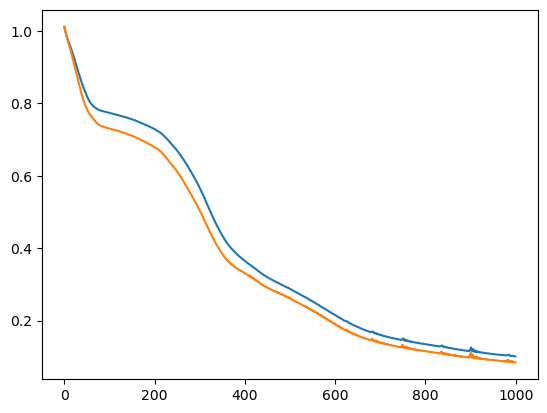

In [63]:
# model,train_set,val_set,epochs,lr,optimizer,loss_fn,device
dmlp, train_loss, val_loss = train(
    dmlp, train_loader, val_loader, 1000, 1e-3, AdamW, nn.MSELoss(), "cuda"
)
plt.plot(train_loss)
plt.plot(val_loss)

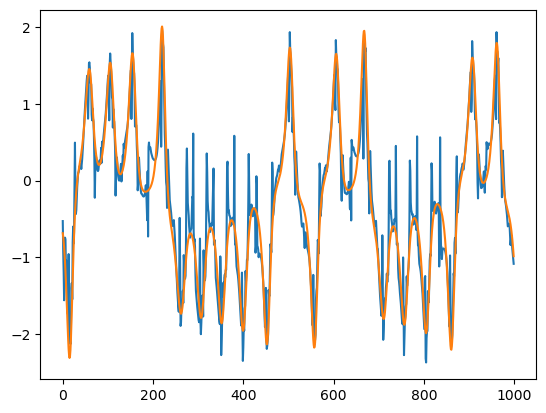

In [65]:
#plot predictions
dmlp.eval()
pred = dmlp(train_data.to("cuda"))[0].detach().cpu().numpy()
plt.figure()
plt.plot(pred[0])
plt.plot(train_data[0])